Hao Wang

In order to successfully complete this assignment, you must follow all instructions in this notebook and upload your edited ipynb file with your answers on or before **11:59pm on Friday Feb. 22nd**.

**BIG HINT:** Read the entire homework before starting.  

# In-Class Assignment: Cramer's Rule

|   |   |
|---|---|
| <img src="https://upload.wikimedia.org/wikipedia/en/b/b7/Cosmo_Kramer.jpg">  | <img src="http://www.mathnstuff.com/math/algebra/gif/asys1.gif" alt="Depiction of Cramer's Rule with two equations and two variables">  |   
| [Cosmo Kramer from Sienfield (No relation)](https://en.wikipedia.org/wiki/Cosmo_Kramer)  | Image from:[http://www.mathnstuff.com/](http://www.mathnstuff.com/)  | 


    

### Outline for Homework 3

</p>
1. One application of determinants
1. Algorithm to calculate the determinant
1. Elimination method for evaluating a determinant
1. Determinant timing study
1. Using Cramer's rule to solve $Ax=b$
6. Timing study comparing Cramer's rule with Gauss-Jordan

# 1. One interplation of determinants

The following is an application of determinats. Watch this!

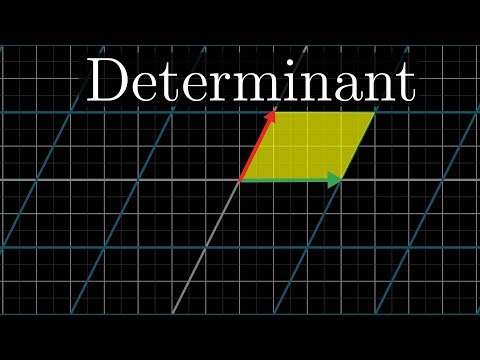

In [60]:
from IPython.display import YouTubeVideo
YouTubeVideo("Ip3X9LOh2dk",width=640,height=360)

For fun, we will recreate some of the video's visualizations in python. 
It was a little tricky to get the aspect ratios correct but here is some code I managed to get to work. 

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np

In [84]:
# Lets define somme points that form a Unit Cube
points = np.array([[0, 0, 0],
                  [1, 0, 0 ],
                  [1, 1, 0],
                  [0, 1, 0],
                  [0, 0, 1],
                  [1, 0, 1 ],
                  [1, 1, 1],
                  [0, 1, 1]])

points = np.matrix(points)

In [85]:
#Here is some code to build cube from https://stackoverflow.com/questions/44881885/python-draw-3d-cube

def plot3dcube(Z):
    
    if type(Z) == np.matrix:
        Z = np.asarray(Z)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    r = [-1,1]

    X, Y = np.meshgrid(r, r)
    # plot vertices
    ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])

    # list of sides' polygons of figure
    verts = [[Z[0],Z[1],Z[2],Z[3]],
     [Z[4],Z[5],Z[6],Z[7]], 
     [Z[0],Z[1],Z[5],Z[4]], 
     [Z[2],Z[3],Z[7],Z[6]], 
     [Z[1],Z[2],Z[6],Z[5]],
     [Z[4],Z[7],Z[3],Z[0]], 
     [Z[2],Z[3],Z[7],Z[6]]]

    #alpha transparency was't working found fix here: 
    # https://stackoverflow.com/questions/23403293/3d-surface-not-transparent-inspite-of-setting-alpha
    # plot sides
    ax.add_collection3d(Poly3DCollection(verts, 
     facecolors=(0,0,1,0.25), linewidths=1, edgecolors='r'))
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ## Weird trick to get the axpect ratio to work.
    ## From https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
    ax.set_aspect('equal')
    mx = np.amax(Z, axis=0)
    mn = np.amin(Z, axis=0)
    max_range = mx-mn

    # Create cubic bounding box to simulate equal aspect ratio
    Xb = 0.5*max_range.max()*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(max_range[0])
    Yb = 0.5*max_range.max()*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(max_range[1])
    Zb = 0.5*max_range.max()*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(max_range[2])
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
       ax.plot([xb], [yb], [zb], 'w')

    plt.show()

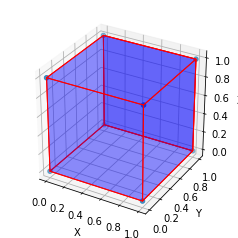

In [64]:
plot3dcube(points)

<font color='red'>**Question:**</font> Generate the $3\times 3$ matrix used in the video (around 6'50'') and apply that matrix to the points in the unit cube.  Use ```plot3dcube``` to show the resulting transformed points. 

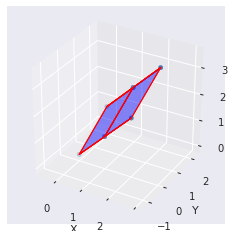

In [130]:
P = np.matrix([[1,0,1],[0.5,1,1.5],[1,0,1]])
points = points*P
plot3dcube(points)

&#9989; <font color='red'>**QUESTION:**</font> In the video, the determinant was shown to be what value in 2D? 

The determinant is 0 in 2D. 

---
# 2. Algorithm to calculate the determinant
Consider the following recursive algorithm (algorithm that calls itself) to determine the determinate of a $n\times n$ matrix $A$ (denoted $|A|$), which is the sum of the products of the elements of any row or column. i.e.:

$$i\text{th row expansion:     } |A| = a_{i1}C_{i1} + a_{i2}C_{i2} + \ldots + a_{in}C_{in} $$
$$j\text{th column expansion:     } |A| = a_{1j}C_{1j} + a_{2j}C_{2j} + \ldots + a_{nj}C_{nj} $$

where $C_{ij}$ is the cofactor of $a_{ij}$ and is given by:

$$ C_{ij} = (-1)^{i+j}|M_{ij}|$$

and $M_{ij}$ is the matrix that remains after deleting row $i$ and column $j$ of $A$.

Using the above steps, the determinant can be calculated in $O(n!)$ time!.  

Here is some code that tries to implement this algorithm.  

In [89]:
## Import our standard packages packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
sym.init_printing(use_unicode=True)

In [87]:
import copy
import random

def makeM(A,i,j):
    ''' Deletes the ith row and jth column from A'''
    M = copy.deepcopy(A)
    del M[i]
    for k in range(len(M)):
        del M[k][j]
    return M

def mydet(A):
    '''Calculate the determinant from list-of-lists matrix A'''
    n = len(A)
    if n == 2:
        det = (A[0][0]*A[1][1] - A[1][0]*A[0][1]) 
        return det
    det = 0
    i = 0
    for j in range(n):
        M = makeM(A,i,j)
        
        #Calculate the determinant
        det += (A[i][j] * ((-1)**(i+j+2)) * mydet(M))
        
    return det

The following code generates an $n \times n$ matrix with random values from 0 to 10.  
Run the code multiple times to get different matrices:

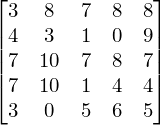

In [98]:
#generate Random Matrix and calculate it's determinant using numpy
n = 5
s = 10
A = [[round(random.random()*s) for i in range(n)] for j in range(n)]

#print matrix
sym.Matrix(A)

&#9989; <font color='red'>**DO THIS:**</font> Use the randomly generated matrix ($A$) to test the above ```mydet``` function and compare your result to the ```numpy.linalg.det``` function.

In [99]:
A_my = mydet(A)
print(A_my)
    
A_lin = np.linalg.det(A)
print(A_lin)


-5480
-5480.000000000003


&#9989; <font color=red>**QUESTION:**</font> Are the answers to ```mydet``` and ```numpuy.linalg.det``` exactly the same every time you generate a different random matrix?  If not, explain why.

No, mydet and numpy.linalg.det did not produce exactly the same answer. Sometimes the answer from mydet is a little bit smaller than numpy.linalg.det, and also a little bit bigger than numpy.linalg.det. The reason is about their different mechanisms. function of mydet used smaller matrix, but in numpy, which used the determinant is computed via LU factorization using the LAPACK routine z/dgetrf. 

&#9989; <font color=red>**QUESTION:**</font> On line 24 of the above code, you can see that algorithm calls itself.  Explain why this doesn't run forever.

Because there is a if function, which restricted when n =2, the function goes to stop. More specifically, the size of matrix got smaller and smaller, until n = 2. And then we could get this determinant smallest matrix, which in turn to calculate the bigger matrix. So, it would not run forever. 

# 3. Elimination method for evaluating a determinant

Assume the following is true

> The determinant of a triangular matrix is the product of its diagonal elements.

If we transform a $n\times n$ matrix $A$ into it's upper triangular form, we can calculate the determinant of $A$ if we keep track of the elementary row operations and adjust the upper triangular determinate using the following rules:

1. Add a multiple of one row to another. This transform leaves the determinant unchanged.
2. Interchange two rows of $A$. This transformation multiplies the determinant by -1. 
3. Multiply one row by $c$. This transformation multiplies the determinant by $c$

&#9989; <font color=red>**QUESTION:**</font> What is the computational complexity of using elimination method (Gauss-Jordan) for evaluating the determinant? Explain how you came up with this estimation and/or provide a reference.

About the computational complexity of using elimination method,  you add multiples of one row to another until all entries below the main diagonal are 0. The determinant (which is unchanged by these actions) is then the product of the diagonal entries. Machines can do such things for n by n matrices with n in the hundreds or thousands, but people find the exercise a bit dull(from the http://math.mit.edu/classes/18.013A/HTML/chapter04/section03.html). 

More importantly, Computationally, for an n × n matrix, this method needs only O(n3) arithmetic operations, while solving by elementary methods requires O(2n) or O(n!) operations. Even on the fastest computers, the elementary methods are impractical for n above 20.(from the website: https://en.wikipedia.org/wiki/Gaussian_elimination) 




# 4. Determinant timing study

&#9989; <font color=red>**DO THIS:**</font> In this part of the homework, we want you to do a timing study to measure the time taken to run the ```mydet``` algorithm defined in part 2 and compare it to the elimination (Gaussian) method for evaluating a determinant as described in part 3.  Assume that the ```numpy.linalg.det``` function uses elimination method to calculate the determinant.  

Here is the basic structure of your timing study:

1. Initialize two empty lists called ```my_det_time``` and ```np_det_time```.
2. Loop over values of $n$ (2, 3, 4, 5, 6, 7, 8, 9)  **HINT:** Do NOT make $n$ bigger than 9.  If you do, the ```mydet``` function will take a very long time.
3. For each value of $n$, generate a list-of-lists of size $n \times n$ of random values to serve as matrix $A$.
4. For each matrix $A$, use the time.clock() function to calculate the time it takes to find the determinant using the ```mydet``` function and append that time (in seconds) to the ```my_det_time``` list.
5. For each matrix $A$, use the time.clock() function to calculate the time it takes to find the determinant using the ```numpy``` determinate function and append that time (in seconds) to the ```numpy_time``` list.
6. Plot your results (Make sure you label your figure appropriately)

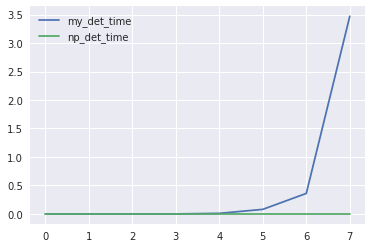

In [113]:
import time
import seaborn as sns

sns.set()

my_det_time = []
np_det_time = []


for n in range(2,10):
    A = [[round(random.random()*10) for i in range(n)] for j in range(n)]
    start = time.clock()
    mydet(A)
    end= time.clock()
    my_det_time.append(end-start)
    
    start = time.clock()
    np.linalg.det(A)
    end= time.clock()
    np_det_time.append(end-start)
    
plt.plot(my_det_time, label='my_det_time')
plt.plot(np_det_time,label='np_det_time')
plt.legend()





---
# 5. Using Cramer's rule to solve $Ax=b$

Let $Ax = b$ be a system of $n$ linear equations in $n$ variables such that $|A| \neq 0$. the system has a unique solution given by:

$$x_1 = \frac{|A_1|}{|A|}, x_2 = \frac{|A_2|}{|A|}, \ldots,  x_n = \frac{|A_n|}{|A|}$$

where $A_i$ is the matrix obtained by replacing column $i$ of $A$ with $b$ (See diagram at the beginning of this homework). The following function generates $A_i$ by replacing the $i$th column of $A$ with $b$:

In [115]:
def makeAi(A,i,b):
    
    '''Replace the ith column in A with b'''
    Ai = copy.deepcopy(A)
    for j in range(len(Ai)):
        Ai[j][i] = b[j][0]
    return Ai


&#9989; <font color=red>**DO THIS:**</font> Create a new function called ```cramersRule```, which takes $A$ and $b$ and returns $x$ using the Cramer's rule. **Note:** Use ```numpy``` and NOT ```mydet``` to find the required determinants. ```mydet``` is too slow. 

In [116]:
# Stub code. Replace the np.linalg.solve code with your answer

def cramersRule(A,b):
    x = []
    n = len(A)
    
    for a in range(n):
        Ai = makeAi(A,a,b)
        de = np.linalg.det(Ai)
        
        B = np.linalg.det(A)
        x.append(de/B)
        
    return x
    




&#9989; <font color=red>**QUESTION:**</font> Test your ```cramersRule``` function on the following system of linear equations:

$$ x_1 + 2x_2 = 3$$
$$3x_1 + x_2 = -1$$

In [117]:
A = [[1,2],[3,1]]
b = [[3],[-1]]

cramersRule(A,b)


&#9989; <font color=red>**QUESTION:**</font> Verify the above answer by using the ```np.linalg.solve``` function:

In [118]:
np.linalg.solve(A,b)

array([[-1.],
       [ 2.]])

&#9989; <font color=red>**QUESTION:**</font> Test your ```cramersRule``` function on the following system of linear equations and verify the answer by using the ```np.linalg.solve``` function: 

$$ x_1 + 2x_2 +x_3 = 9$$
$$ x_1 + 3x_2 - x_3 = 4$$
$$ x_1 + 4x_2 - x_3 = 7$$

In [122]:
A = [[1,2,1],[1,3,-1],[1,4,-1]]
b = [[9],[4],[7]]
print(cramersRule(A,b))

print(np.linalg.solve(A,b))

[-0.9999999999999979, 3.0, 3.999999999999999]
[[-1.]
 [ 3.]
 [ 4.]]


&#9989; <font color=red>**QUESTION:**</font> Cramer's rule is a $O(n!)$ algorithm and the Gauss-Jordan (or Gaussian) elimination is $O(n^3)$.  What advantages does Cramer's rule have over elimination?

Cramer's rule could gives us a direct way to express algebraic relations between the solution to a system and determinants derived from the coefficient matrix.

# 6. Timing study comparing Cramer's rule with Gaussian
The following code conducts a timing study to compare your Cramer's rule with Gaussian (aka ```numpy.linalg.solve```).  
The code generates a random system of linear equations in the form of $Ax=b$ and then attempt to solve them using both methods.  

In [124]:
import time

n_list = [2, 3, 4, 5, 6, 7, 8, 9, 10 , 11, 12, 13, 14, 15 ]
cramer_time = []
numpy_time = []

for n in n_list:
    #Generate random nxn array of two lists
    A = [[0,0],[0,0]]
    while np.linalg.det(A) == 0:
        A = [[random.random() for i in range(n)] for j in range(n)]
    b = [[random.random()] for i in range(n)]
    
    start = time.time()
    x = cramersRule(A, b)
    stop = time.time()
    cramer_time.append(stop - start)
    
    #Convert the lists to a numpy matrix
    nA = np.matrix(A)
    nb = np.matrix(b)

    #Calculate the time it takes to run the numpy matrix. 
    start = time.time()
    x2 = np.linalg.solve(A,b)
    stop = time.time()
    numpy_time.append(stop - start)

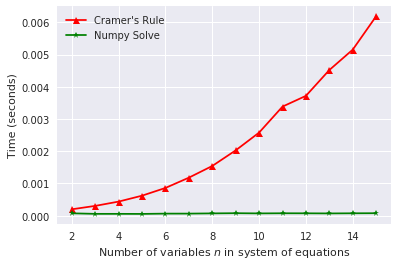

In [125]:
plt.plot(n_list, cramer_time, 'r-^', label="Cramer's Rule")
plt.plot(n_list, numpy_time, 'g-*', label='Numpy Solve')
plt.xlabel('Number of variables $n$ in system of equations');
plt.ylabel('Time (seconds)');
plt.legend();

Based on the above results, you can see that the numpy algorithm not only is faster but also "scales" at a slower rate than cramer's rule.  

&#9989; <font color=red>**QUESTION:**</font> The following is a list of all of the different algorithms we have used so far to solve systems of equations in the form of $Ax=b$. Do the following:

1. Include the missing big-O notations. (Jacobi and Gauss-Sideal provided).
2. Reorder the algorithms from slowest to fastest. 
3. Include any limitations for each approach (example provided for Jacobi).

* One iteration of the Jacobi method is $O(n^2)$ (many iterations are needed) [REF](http://shodhganga.inflibnet.ac.in/bitstream/10603/148188/9/09_chapter%203.pdf) 
    - Only works for diagonally dominant matrices
* One iteration of the Gauss-Sideal method is $O(n^2)$ (many iterations are needed) [REF](http://shodhganga.inflibnet.ac.in/bitstream/10603/148188/9/09_chapter%203.pdf)

* Cramer's rule is $O(n!)$
     - when there is a difference between the number of variables and the number of equations, or the determinant is 0, the cramer's rule cannot work. 
* Elimination method is $O(n^3)$


     -One possible problem is numerical instability, caused by the possibility of dividing by very small numbers.
      (from the website: https://en.wikipedia.org/wiki/Gaussian_elimination#Computational_efficiency)
    
    
* LU Decomposition and then forward and backward substitution is $O(n ^ (2.7))$
   - The Gaussian elimination (or LU decomposition) process may introduce fill-in, i.e., 𝐿 and 𝑈 may have nonzero elements in locations where the original matrix 𝐴 has zeros. If the amount of fill-in is significant, then applying the direct method may become costly.(from the website: https://math.stackexchange.com/questions/2462931/what-are-the-benefits-of-iterative-method-against-lu-decomposition) 
   In addition, in the larger system, LU decomposition is not very useful. 


-----
### Congratulations, we're almost done!

Now, you just need to submit this assignment by uploading it to the course <a href="https://d2l.msu.edu/">Desire2Learn</a> web page for the homework's dropbox (Don't forget to add your names in the first cell).


&#169; Copyright 2018,  Michigan State University Board of Trustees